Грузим датасеты на коллаб

In [1]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 5.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=ea1e5cff300027a2bd89c7a1bb319f90c1c07f923937c9b96da9405ea1ecca52
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


Грузим Kaggle json, чтоб можно было качать датасеты прямо на колаб

In [3]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [5]:
!kaggle competitions download -c home-credit-default-risk

 99% 680M/688M [00:09<00:00, 79.3MB/s]
100% 688M/688M [00:09<00:00, 75.7MB/s]


In [6]:
!unzip home-credit-default-risk.zip

Archive:  home-credit-default-risk.zip
  inflating: HomeCredit_columns_description.csv  
  inflating: POS_CASH_balance.csv    
  inflating: application_test.csv    
  inflating: application_train.csv   
  inflating: bureau.csv              
  inflating: bureau_balance.csv      
  inflating: credit_card_balance.csv  
  inflating: installments_payments.csv  
  inflating: previous_application.csv  
  inflating: sample_submission.csv   


Все! Скачали все датасеты. Нау итс тайм то мейк сам датасайенс

Так. Ну тут у нас много документов и таблиц еще и небось со связями в духе 1 к многим. Значит по идее нам нужно как-то по этим данным собирать отдельные фичи (Усреднять или объеденять), Но для начала загрузим основные датасеты

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [68]:
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')
bureau = pd.read_csv('bureau.csv')
submission = pd.read_csv('sample_submission.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
credit_card_balance = pd.read_csv('credit_card_balance.csv')
prev_app = pd.read_csv('previous_application.csv')

Для того чтоб натренировать модель нам нужно как-то предобработать данные из других столбцов и добавить их в основной датафрейм.

Но займемся этим немного позже, а пока что попробуем просто по основному документу взять какие-нибудь признаки что бы просто получить какой-нить скор

In [37]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder,StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import seaborn as sns

В начале посмотрим в каких колонках больше всего нанов и других плохих штук, колонки в которых около половины пустых значений, я дропну потому что логично они мало влияют на данные в целом

In [69]:
rows = train.shape[0]
missed_percents = pd.concat([(train.isnull().sum() /rows).sort_values(ascending=False)],axis=1,keys=['percent'])
fields_for_droping = missed_percents[missed_percents['percent']>0.5].index.to_list()
train = train.drop(fields_for_droping,axis=1)
test = test.drop(fields_for_droping,axis=1)

In [70]:
train.shape

(307511, 81)

In [71]:
print(train.isna().sum().max())

153020


Все остальные nan значения заполним средними значениями

In [72]:
# Отдельно разобьем категориальные и численные признаки, чтоб потом прогнать их через labelEncoder
number_columns = train.select_dtypes(exclude = ["object"]).columns
category_columns = train.select_dtypes(include = ["object"]).columns
print(f"и того кагеогий у нас {len(number_columns)} а чисел {len(category_columns)}")

и того кагеогий у нас 68 а чисел 13


In [73]:
for i, column in enumerate(category_columns):
  median = train[column].value_counts().idxmax()
  train[column].fillna(median, inplace=True)
  train[column] = LabelEncoder().fit_transform(train[column])
for column in number_columns:
    train[column].fillna(train[column].median(), inplace=True)

In [74]:
# Проверяем, есть ли у нас нулы
print(train.isna().sum().max())

0


Теперь посмотрим что у нас по сбалансированости предсказаний

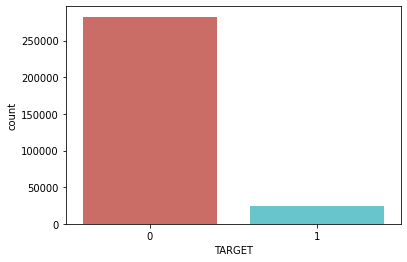

In [75]:
sns.countplot(x='TARGET',data=train,palette='hls')
plt.show()

Как и предполагалось оч много ноликов, Яб сразу заюзал SMOTE и на генерил новых еденичек чтоб усреднить,
но пока просто давайте без кроссвалидации и пр сразу полезем обучать модель, чтоб получить маленький скор и улучшать его вдальнейшем

In [76]:
# Еще немного подшаманим тест чтоб все сходилось
number_columns_test = test.select_dtypes(exclude = ["object"]).columns
category_columns_test = test.select_dtypes(include = ["object"]).columns
most_freq_cat_nans_test = []
for i, column in enumerate(category_columns_test):
  median = test[column].value_counts().idxmax()
  test[column].fillna(median, inplace=True)
  test[column] = LabelEncoder().fit_transform(test[column])
for column in number_columns_test:
    test[column].fillna(test[column].median(), inplace=True)

# Энкодим категориальный фичи
print(test.isna().sum().max()) # checking

0


In [77]:
def train_model(data,target):
  data = data.dropna()
  X = data.loc[:, data.columns != target]
  Y = data.loc[:, data.columns == target]
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)
  model = LogisticRegression()
  model.fit(X_train,Y_train)
  predict = model.predict_proba(X_test)
  print(f"roc auc {roc_auc_score(Y_test,predict)}")


In [79]:
target = "TARGET"
X = train.loc[:, train.columns != target]
Y = train.loc[:, train.columns == target]
model = LogisticRegression(solver='liblinear', penalty='l2', tol=1e-4, multi_class='ovr', random_state=1)
model.fit(X,Y)
predict = model.predict_proba(test)[:,1]
submission['TARGET'] = predict
submission.to_csv('submission.csv', index = None)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [80]:
!kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "First atempt"

100% 1.25M/1.25M [00:02<00:00, 482kB/s]
Successfully submitted to Home Credit Default Risk

Пока первый результат .62353, что как я понимаю чуть лучше чем просто 0.5

# Часть 2: **Custom features**

Добавим еще полезных фичей

In [81]:
# идеи для этих фичей любезно подсмотрел у товарищей по группе
train['DAYS_EMPLOYED_PERC'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
train['INCOME_CREDIT_PERC'] = train['AMT_INCOME_TOTAL'] / train['AMT_CREDIT']
train['INCOME_PER_PERSON'] = train['AMT_INCOME_TOTAL'] / train['CNT_FAM_MEMBERS']

test['DAYS_EMPLOYED_PERC'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']
test['INCOME_CREDIT_PERC'] = test['AMT_INCOME_TOTAL'] / test['AMT_CREDIT']
test['INCOME_PER_PERSON'] = test['AMT_INCOME_TOTAL'] / test['CNT_FAM_MEMBERS']

добавим датасет по кредитному бюро, усредним фичи и добавим в датасеты

In [82]:
b_cat_features = bureau.select_dtypes(include = ["object"]).columns
bureau = pd.get_dummies(bureau, columns = b_cat_features, dummy_na = True)
# устредняем значения
bureau_avg = bureau.groupby('SK_ID_CURR').mean()
bureau_avg['buro_count'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
bureau_avg.columns = ['b_' + f_ for f_ in bureau_avg.columns]
train = train.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')

In [83]:
cat_features = prev_app.select_dtypes(include = ["object"]).columns
prev_app = pd.get_dummies(prev_app, columns = cat_features, dummy_na = True)
prev_apps_count = prev_app[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
prev_app['SK_ID_PREV'] = prev_app['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])

## Average values for all other features in previous applications
prev_apps_avg = prev_app.groupby('SK_ID_CURR').mean()
prev_apps_avg.columns = ['p_' + col for col in prev_apps_avg.columns]
train = train.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')

Добавили фичи и снова дропаем полупустые

In [84]:
rows = train.shape[0]
missed_percents = pd.concat([(train.isnull().sum() /rows).sort_values(ascending=False)],axis=1,keys=['percent'])
fields_for_droping = missed_percents[missed_percents['percent']>0.5].index.to_list()
train = train.drop(fields_for_droping,axis=1)
test = test.drop(fields_for_droping,axis=1)

убираем наны

In [85]:
number_columns = train.select_dtypes(exclude = ["object"]).columns
category_columns = train.select_dtypes(include = ["object"]).columns
print(f"и того кагеогий у нас {len(category_columns)} а чисел {len(number_columns)}")

и того кагеогий у нас 0 а чисел 300


In [86]:
for i, column in enumerate(category_columns):
  median = train[column].value_counts().idxmax()
  train[column].fillna(median, inplace=True)
  train[column] = LabelEncoder().fit_transform(train[column])
for column in number_columns:
    train[column].fillna(train[column].median(), inplace=True)

In [87]:
# Еще немного подшаманим тест чтоб все сходилось
number_columns_test = test.select_dtypes(exclude = ["object"]).columns
category_columns_test = test.select_dtypes(include = ["object"]).columns
most_freq_cat_nans_test = []
for i, column in enumerate(category_columns_test):
  median = test[column].value_counts().idxmax()
  test[column].fillna(median, inplace=True)
  test[column] = LabelEncoder().fit_transform(test[column])
for column in number_columns_test:
    test[column].fillna(test[column].median(), inplace=True)

# Энкодим категориальный фичи
print(test.isna().sum().max()) # checking

0


Обучаем и отправляем на кегл

In [88]:
target = "TARGET"
X = train.loc[:, train.columns != target]
Y = train.loc[:, train.columns == target]
model = LogisticRegression(solver='liblinear', penalty='l2', tol=1e-4, multi_class='ovr', random_state=1)
model.fit(X,Y)
predict = model.predict_proba(test)[:,1]
submission['TARGET'] = predict
submission.to_csv('submission.csv', index = None)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [89]:
!kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "Add new features, and other"

100% 1.25M/1.25M [00:01<00:00, 768kB/s]
Successfully submitted to Home Credit Default Risk

чот скор упал( 0.60228

Добавим woe

In [90]:
def iv_woe(data, target, bins=10, show_woe=False):
    #Empty Dataframe
    newDF, woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
            d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
            d.columns = ['Cutoff', 'N', 'Events']
            d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
            d['Non-Events'] = d['N'] - d['Events']
            d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
            d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
            d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
            d.insert(loc=0, column='Variable', value=ivars)
            print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
            temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
            newDF=pd.concat([newDF,temp], axis=0)
            woeDF=pd.concat([woeDF,d], axis=0)
        
    if show_woe == True:
        print(d)
    
    return newDF, woeDF

In [91]:
iv, woe = iv_woe(data = train, target = 'TARGET', bins=10, show_woe = True)

Information value of NAME_CONTRACT_TYPE is 0.015039
Information value of CODE_GENDER is 0.038599
Information value of FLAG_OWN_CAR is 0.006597
Information value of FLAG_OWN_REALTY is 0.000505
Information value of NAME_TYPE_SUITE is 0.001402
Information value of NAME_INCOME_TYPE is 0.058381
Information value of NAME_EDUCATION_TYPE is 0.050836
Information value of NAME_FAMILY_STATUS is 0.021711
Information value of NAME_HOUSING_TYPE is 0.01573
Information value of FLAG_MOBIL is 2.9e-05
Information value of FLAG_EMP_PHONE is 0.032907
Information value of FLAG_WORK_PHONE is 0.010329
Information value of FLAG_CONT_MOBILE is 2e-06
Information value of FLAG_PHONE is 0.007942
Information value of FLAG_EMAIL is 4.2e-05
Information value of REGION_RATING_CLIENT is 0.048317
Information value of REGION_RATING_CLIENT_W_CITY is 0.051201
Information value of WEEKDAY_APPR_PROCESS_START is 0.000677
Information value of REG_REGION_NOT_LIVE_REGION is 0.000393
Information value of REG_REGION_NOT_WORK_REGI

In [92]:
unreliable_f = iv.loc[iv['IV'] < 0.01]

train = train.drop(unreliable_f['Variable'], axis=1)
test = test.drop(unreliable_f['Variable'], axis=1)

In [49]:
#train = train.drop(['TARGET'], axis=1)
#train = train.drop(['SK_ID_CURR'], axis=1)

In [56]:
train.shape, test.shape

((307511, 236), (48744, 235))

In [93]:
print(set(train.columns)-set(test.columns))
y = train['TARGET']
train = train.drop(['TARGET'], axis=1)


{'TARGET'}


In [94]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train) # считаем значения
test_scaled = scaler.transform(test) # используем

In [95]:
logreg = LogisticRegression(solver='liblinear', penalty='l2', tol=1e-4, multi_class='ovr', random_state=1)
X_train, X_test, y_train, y_test = train_test_split(train_scaled, y, test_size = 0.3, random_state = 200)
print("X Training shape", X_train.shape)
print("X Testing shape", X_test.shape)
print("Y Training shape", y_train.shape)
print("Y Testing shape", y_test.shape)
logreg.fit(X_train, y_train)
y_pred_p = logreg.predict_proba(X_test)[:,1]

print("ROC",  roc_auc_score(y_test, y_pred_p))

X Training shape (215257, 242)
X Testing shape (92254, 242)
Y Training shape (215257,)
Y Testing shape (92254,)
ROC 0.7567499497125728


In [96]:
model = LogisticRegression(solver='liblinear', penalty='l2', tol=1e-4, multi_class='ovr', random_state=1)
model.fit(train,y)
predict = model.predict_proba(test)[:,1]
submission['TARGET'] = predict
submission.to_csv('submission.csv', index = None)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [97]:
!kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "Please need more score"

100% 1.25M/1.25M [00:02<00:00, 507kB/s]
Successfully submitted to Home Credit Default Risk

Только хуже и хуже( непонятно почему